In [1]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 3.5MB/s 
     |████████████████████████████████| 655kB 47.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/common/"

In [0]:
import os
import argparse
import logging
import json
import re

import torch
import torch.optim as optimizers
import torch.nn as nn

from sklearn.metrics import classification_report

from torch.utils.data import DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel

from tqdm import tqdm_notebook, tnrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from multihead_v2 import MultiheadConfig
from tripadvisor import TripadvisorDataset
from organic import OrganicDataset
from semEval import semEvalDataset

In [0]:
def do_train_step(domain,isEval=False):
    """
    Wraps a training step as it is the same for all sets.
    :param batch: the batch
    :param domain: the config object for the current domain
    :return: the loss for the step
    """
    data = {"aspect": batch['aspect'].float().to(device), "polarity": batch['polarity'].float().to(device),
            "joint": batch['joint'].float().to(device)}
    sequences = batch['sequence'].to(device)
    masks = batch['mask'].to(device)

    optim.zero_grad()

    with torch.no_grad():
        embeddings, _ = bert(sequences, token_type_ids=None, attention_mask=masks)

    logits = model(embeddings[-1].permute(1,0,2))
    logits = logits[domain["name"]]

    # backprop
    losses = {}
    for head in domain["heads"]:
        if domain["heads"][head]:
            losses[head] = loss_fun(logits[head], data[head])

    if (len(losses) == 0):
        return 0
    loss = sum(losses.values())
    
    if (isEval == False):
        loss.backward()
        optim.step()
    return loss.item()

In [0]:
def inf_iterator(dl):
    while True:
        for x in iter(dl):
            yield x

In [0]:
def readConfig():
    args = argparse.Namespace()
    args.version = "v1"
    args.steps = 200
    args.batch = 64
    args.concat = False
    args.tripad = sharedGFolderPath + 'data/tripadvisor/'
    args.organic = sharedGFolderPath + 'data/organic/'
    args.semEvalDir = sharedGFolderPath + 'data/semeval/'
    args.semEval = ['semevalRestaurants_combi14', 'semevalLaptops_combi14', 'semevalRestaurants_combi16', 'semevalLaptops_combi16']
    args.save_dir = sharedGFolderPath + 'model/test/'
    args.eval_interval = 50
    
    return args

In [0]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',datefmt='%m/%d/%Y %H:%M:%S',level=logging.INFO)
logger = logging.getLogger(__name__)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'   
args = readConfig()
with open(os.path.join(sharedGFolderPath, 'config.json')) as json_data_file:
    config = json.load(json_data_file)

In [24]:
# multi-head model
model = MultiheadConfig(config)
model.to(device)

# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
07/16/2019 13:41:12 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/16/2019 13:41:12 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
07/16/2019 13:41:12 - INFO - 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=

In [25]:
# FOR DATA LOADING

tripad = TripadvisorDataset(args.tripad, tokenizer, train=True)
tripad_train, tripad_eval = torch.utils.data.random_split(tripad, lengths=[int(len(tripad) * 0.9), len(tripad) - int(len(tripad) * 0.9)])
tripad_train_loader = DataLoader(tripad_train, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
tripad_eval_loader = DataLoader(tripad_eval, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
tripad_test = TripadvisorDataset(args.tripad, tokenizer, train=False)
tripad_test_loader = DataLoader(tripad_test, batch_size=64,num_workers=16, drop_last=False, shuffle=False)
config[0]["data_loader"] = tripad_train_loader
config[0]["data_loader_eval"] = tripad_eval_loader
config[0]["data_loader_test"] = tripad_test_loader
config[0]["data_iter"] = inf_iterator(tripad_train_loader)
config[0]["data_test"] = tripad_test

organic_train = OrganicDataset(args.organic, tokenizer, train=0)
organic_train_loader = DataLoader(organic_train, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
organic_eval = OrganicDataset(args.organic, tokenizer, train=1)
organic_eval_loader = DataLoader(organic_eval, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
organic_test = OrganicDataset(args.organic, tokenizer, train=2)
organic_test_loader = DataLoader(organic_test, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
config[1]["data_loader"] = organic_train_loader
config[1]["data_loader_eval"] = organic_eval_loader
config[1]["data_loader_test"] = organic_test_loader
config[1]["data_iter"] = inf_iterator(organic_train_loader)
config[1]["data_test"] = organic_test

index = 2
for domain in config:
    if domain["name"] == "trip" or domain["name"] == "organic":
        continue
    dataset = semEvalDataset(args.semEvalDir, args.semEval[index-2], tokenizer, train=True)
    dataset_train, dataset_eval = torch.utils.data.random_split(dataset, lengths=[int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)])
    config[index]["data_loader"] = DataLoader(dataset_train, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=False)
    config[index]["data_loader_eval"] = DataLoader(dataset_eval, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=False)
    config[index]["data_iter"] = inf_iterator(config[index]["data_loader"])
    dataset_test = semEvalDataset(args.semEvalDir, args.semEval[index-2], tokenizer, train=False)
    config[index]["data_loader_test"] = DataLoader(dataset_test, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=False)
    config[index]["data_test"] = dataset_test
    index += 1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['1GB of RAM', 'Adobe Creative apps', 'Applecare warranty plan', 'CPU', 'Charger', 'Core2 Quad', 'Dashboard', 'Final Cut Pro', 'Toshiba tech support', 'Windows Vista Home Premium', 'Windows XP SP2', 'affordability', 'apple associates', 'bag', 'built in tools', 'clicking buttons', 'command prompt', 'control buttons', 'driver', 'graphic power', 'incase shells', 'key board', 'memory stick', 'motherboard chip', 'operating systems', 'power supply cord', 'presentations', 'resolution', 'screen hinges', 'screen/video resolution', 'securitysoftware', 'service life', 'services', 'size of the screen', 'sound', 'spreadsheets', 'tote', 'vga port'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['1GB of RAM/negative', '1GB of RAM/neutral', 'Adobe Creative apps/neutral', 'Applecare warr

In [0]:
# optimization and loss
optim = optimizers.Adam(model.parameters())
loss_fun = nn.BCEWithLogitsLoss()

In [0]:
logger.info('***** Running training *****')
logger.info('  Steps = %d', args.steps)
logger.info('  Batch size = %d', args.batch)

domain_losses = {}
domain_eval_losses = {}
for domain in config:
    domain_losses[domain["name"]] = []
    domain_eval_losses[domain["name"]] = []
    
# TRAINING LOOP
with tnrange(args.steps, desc="Training Steps") as stepLoop:
    for i in stepLoop:
        for domain in config:
            batch = next(domain["data_iter"])
            current_loss = do_train_step(domain)
            stepLoop.set_postfix(loss=current_loss, domain=domain["name"])
            domain_losses[domain["name"]].append(current_loss)
            if i % 50 == 9:
                print('Step {0} - {1} Loss {2:.4f}'.format(i + 1, domain["name"], current_loss))

        if i % args.eval_interval == args.eval_interval - 1:
            for domain in config:
                loss = 0.0
                with tqdm_notebook(domain["data_loader_eval"]) as evalLoop:
                    for batch in evalLoop:
                        current_loss = do_train_step(domain,isEval=True)
                        loss += current_loss
                        evalLoop.set_postfix(loss=current_loss, domain=domain["name"])

                    domain_eval_losses[domain["name"]].append(loss / len(domain["data_loader_eval"]))
                    print('Evaluation - {0} Loss {1:.4f}'.format(domain["name"], domain_eval_losses[domain["name"]][-1]))

logger.info('Writing model to %s', os.path.join(args.save_dir, '{0}.pt'.format(args.version)))
torch.save(model.state_dict(), os.path.join(args.save_dir, '{0}.pt'.format(args.version)))


07/15/2019 18:53:57 - INFO - __main__ -   ***** Running training *****
07/15/2019 18:53:57 - INFO - __main__ -     Steps = 200
07/15/2019 18:53:57 - INFO - __main__ -     Batch size = 64


Step 10 - trip Loss 1.0530
Step 10 - organic Loss 0.9175
Step 10 - SemEval14res Loss 1.2685
Step 10 - SemEval14lap Loss 0.6679
Step 10 - SemEval16res Loss 0.8399
Step 10 - SemEval16lap Loss 0.5963


Evaluation - trip Loss 0.7647


Evaluation - organic Loss 0.8613


Evaluation - SemEval14res Loss 0.9871


Evaluation - SemEval14lap Loss 0.5319


Evaluation - SemEval16res Loss 0.7143


Evaluation - SemEval16lap Loss 0.3747
Step 60 - trip Loss 0.7270
Step 60 - organic Loss 0.8441
Step 60 - SemEval14res Loss 1.1210
Step 60 - SemEval14lap Loss 0.5155
Step 60 - SemEval16res Loss 0.5947
Step 60 - SemEval16lap Loss 0.4590


Evaluation - trip Loss 0.7079


Evaluation - organic Loss 0.8194


Evaluation - SemEval14res Loss 0.8884


Evaluation - SemEval14lap Loss 0.5491


Evaluation - SemEval16res Loss 0.6141


Evaluation - SemEval16lap Loss 0.3683
Step 110 - trip Loss 0.6547
Step 110 - organic Loss 0.8557
Step 110 - SemEval14res Loss 0.7749
Step 110 - SemEval14lap Loss 0.4229
Step 110 - SemEval16res Loss 0.4037
Step 110 - SemEval16lap Loss 0.2721


Evaluation - trip Loss 0.6913


Evaluation - organic Loss 0.8128


Evaluation - SemEval14res Loss 0.8884


Evaluation - SemEval14lap Loss 0.5989


Evaluation - SemEval16res Loss 0.6776


Evaluation - SemEval16lap Loss 0.3911
Step 160 - trip Loss 0.6759
Step 160 - organic Loss 0.7714
Step 160 - SemEval14res Loss 0.4962
Step 160 - SemEval14lap Loss 0.2267
Step 160 - SemEval16res Loss 0.1972
Step 160 - SemEval16lap Loss 0.1984


Evaluation - trip Loss 0.7185


Evaluation - organic Loss 0.8060


Evaluation - SemEval14res Loss 1.0464


Evaluation - SemEval14lap Loss 0.8353


Evaluation - SemEval16res Loss 0.6950


07/15/2019 19:23:03 - INFO - __main__ -   Writing model to /content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/common/model/v1.pt


Evaluation - SemEval16lap Loss 0.4495



In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

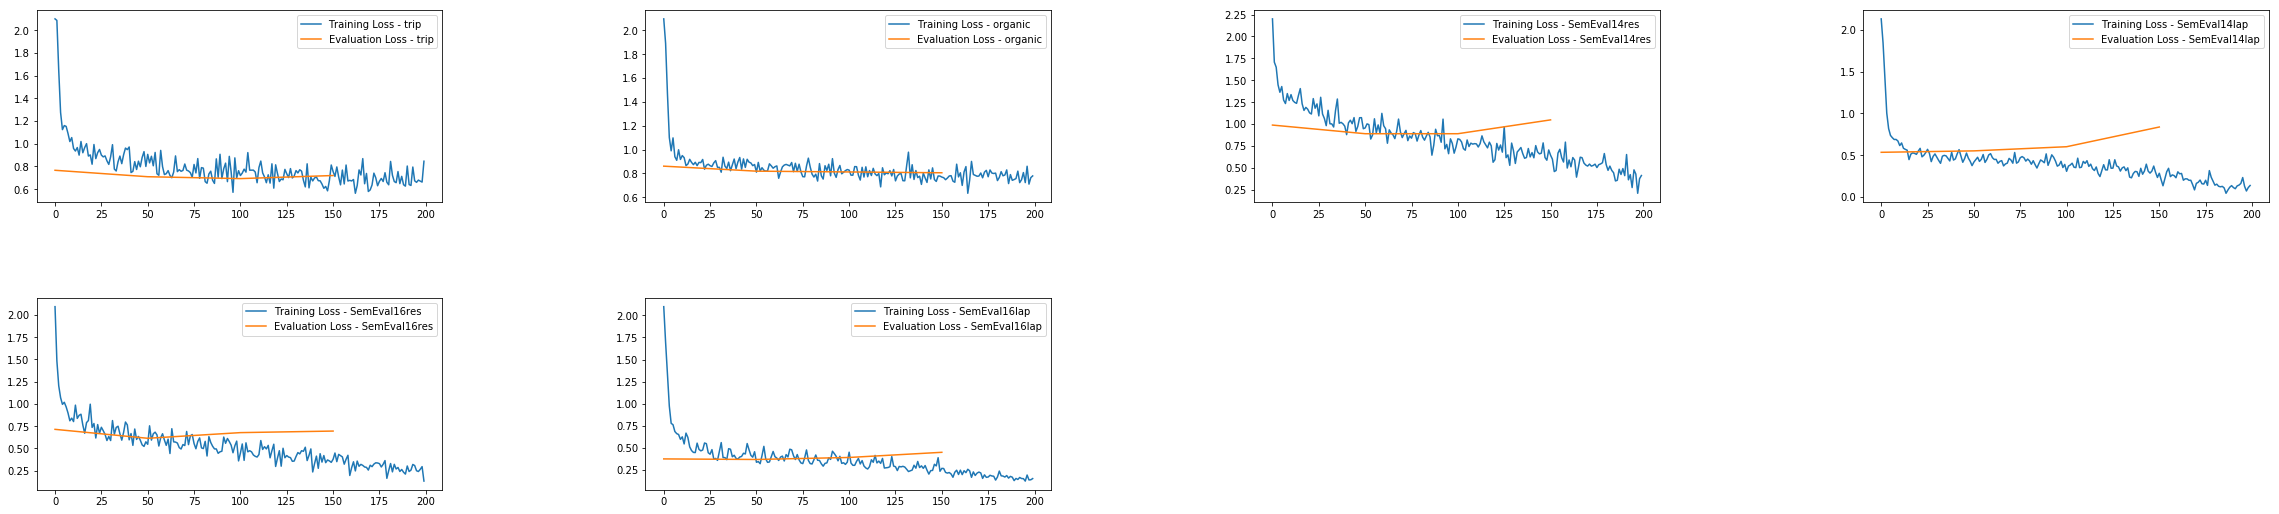

In [0]:
#@title Default title text
'''
domain_losses_mean = {}
for domain in config:
    domain_losses_mean[domain["name"]] = []
    for i in range(len(domain_eval_losses[domain["name"]])):
        domain_losses_mean[domain["name"]].append(np.mean(domain_losses[domain["name"]]
                                                          [i*args.eval_interval:(i+1)*args.eval_interval]))
'''
#plt.figure(figsize=(20,10))
fig = plt.figure(figsize=(40, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i,domain in enumerate(config):
    splt = fig.add_subplot(6, 4, i+1)
    splt.plot(domain_losses[domain["name"]],label='Training Loss - '+domain["name"])
    splt.plot([n*args.eval_interval for n in range(int(args.steps/args.eval_interval))],domain_eval_losses[domain["name"]],label='Evaluation Loss - '+domain["name"])
    splt.legend()
#plt.legend()
fig.show()

## TEST Phase

In [0]:
def do_test_step(domain,batch):
    """
    Wraps a training step as it is the same for all sets.
    :param batch: the batch
    :param domain: the config object for the current domain
    :return: the loss for the step
    """
    data = {"aspect": batch['aspect'].float().to(device), "polarity": batch['polarity'].float().to(device),
            "joint": batch['joint'].float().to(device)}
    sequences = batch['sequence'].to(device)
    masks = batch['mask'].to(device)

    optim.zero_grad()

    with torch.no_grad():
        embeddings, _ = bert(sequences, token_type_ids=None, attention_mask=masks)

    logits = model(embeddings[-1].permute(1,0,2))
    logits = logits[domain["name"]]
    
    preds = {}
    result = {}
    for head in domain["heads"]:
        if domain["heads"][head]:
            apply_sigmoid = torch.sigmoid(logits[head])
            threshold = 0.25 - (domain["classes"][head] - 3)/500
            threshold = threshold if threshold > 0.05 else 0.05
            preds[head] = apply_sigmoid > threshold
            result[head] = {"actual": data[head].cpu().detach().numpy(), "preds": preds[head].float().cpu().detach().numpy(), "sigmoid": apply_sigmoid.float().cpu().detach().numpy()}            
    return result

In [0]:
def evaluate_on_test(domain, class_names):
    all_results = {"aspect":{"actual":[], "preds":[]}, "polarity":{"actual":[], "preds":[]}, "joint":{"actual":[], "preds":[]}}
    for j, batch in enumerate(domain["data_loader_test"]):
        result = do_test_step(domain,batch)
        for head in domain["heads"]:
            if domain["heads"][head]:
                all_results[head]["actual"].extend(result[head]["actual"])
                all_results[head]["preds"].extend(result[head]["preds"])
                
    
    for head in domain["heads"]:
        if domain["heads"][head]:
            #print((domain["name"]+" "+head).title())
            #print(classification_report(np.array(all_results[head]["actual"]), np.array(all_results[head]["preds"]), target_names=class_names[head]))
            cr = classification_report(np.array(all_results[head]["actual"]), np.array(all_results[head]["preds"]), target_names=class_names[head])
            plot_classification_report(cr,title=(domain["name"]+" "+head).title(),shouldPrint=True)
        
    return all_results

In [0]:
# FOR PRINTING PLOT OF CLASSIFICATION REPORT

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', shouldPrint=False):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    plotMat = []
    support = []
    class_names = []
    report_data = []
    for line in lines[2 : (len(lines) - 2)]:
        t = re.split(r'\s{2,}', line.strip())
        if len(t) < 2:
            continue
        
        row = {}
        class_names.append(t[0])
        row['class'] = t[0]
        v = [float(x) for x in t[1: len(t) - 1]]
        row['precision'] = v[0]
        row['recall'] = v[1]
        row['f1_score'] = v[2]
        support.append(int(t[-1]))
        row['support'] = int(t[-1])
        
        #print(v)
        plotMat.append(v)
        report_data.append(row)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))
    if shouldPrint:
        pd.DataFrame.from_dict(report_data).to_csv(os.path.join(args.save_dir, title+'.csv'), index = False)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [0]:
domain = config[1]
class_names = {  'aspect': domain["data_test"].aspect_encoder.classes_,
                                'polarity': domain["data_test"].polarity_encoder.classes_,
                                'joint': domain["data_test"].joint_encoder.classes_  }
head = 'aspect'
#cr = classification_report(np.array(complete_data["organic"][head]["actual"]), np.array(complete_data["organic"][head]["preds"]), target_names=class_names[head])

In [28]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#model.eval()

model = MultiheadConfig(config)
model.load_state_dict(torch.load(os.path.join(args.save_dir, '{0}.pt'.format(args.version))))
model.eval()
model.to(device)

complete_data = {}
for domain in config:
    complete_data[domain["name"]] = evaluate_on_test(domain, {  'aspect': domain["data_test"].aspect_encoder.classes_,
                                'polarity': domain["data_test"].polarity_encoder.classes_,
                                'joint': domain["data_test"].joint_encoder.classes_  })


Output hidden; open in https://colab.research.google.com to view.